# CS 584-A: Natural Language Processing

## Student information
- Full name: Thanapoom Phatthanaphan
- CWID: 20011296

## Homework 2
### Goals
The goal of HW2 is for you to get hands-on experience of implementing RNN and CNN models for the classification task. You will get a deeper understanding of how these models are applied to text data. The skills you learn from using RNN and CNN models can be applied to a wide range of NLP tasks beyond text classification. Additionally, the skills you acquire will be transferable to more advanced topics, such as attention mechanisms, transformers, and other complex architectures. Please feel free to use any packages or libraries in your implementation.

Similar to HW1, all questions are open questions and there is no fixed solution. The difference in data processing, parameter initialization, data split, etc., will lead to the differences in predictions and evaluation results. Therefore, during the grading, the specific values in the results are not required. It is important that you focus on implementing and setting up the pipelines of applying these models to solve the tasks.
### Dataset
The dataset is about the product review dataset from Amazon. Please download it from Canvas. The dataset provides product reviews and overall ratings for 4,195 products. We will consider the fine-grained overall ratings as labels, which are ranging from 1 to 5: highly negative, negative, neutral, positive, and highly positive.

## Task: Sentiment Abalysis with Text Classification
The task is still to perform sentiment analysis, which predicts the sentiments based on the free-text reviews, which is the same as in HW1.

**Differences from HW1**: If you worked on the multi-class classification problem in HW1, please change to work on the binary classification problem in HW2. If you worked on the binary classification problem in HW1, please change to work on the multi-class classification problem in HW2. Please find the details about how to process the labels below.

For the multi-class classification problem, we will have 5 classes in total. To simplify the task as a binary classification problem, we will consider ratings 4 and 5 as positive, and rating 1 and 2 as negative. For data samples with neutral rating 3, you can discard them or simply consider them as either positive or negative samples.

***In the submission, please make sure to clearly mention which task you are solving and how did you prepare the class labels.***

## Task 1: Extraction features

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. Data preparation

In [2]:
# Import necessary libraries for data preparation
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
import string
import re
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Input
import gensim.downloader as api
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### 1.1 Data preprocessing
Download and load the dataset. Please process the reviews by
<br>1) converting all text to lowercase to ensure uniformity.
<br>2) removing punctuations, numbers, and stopwords.
<br>3) tokenizing the reviews into tokens. If you plan to work on the binary classification problem, you will need to assign binary class labels based on the above-mentioned strategy.

In [3]:
# Import dataset
dataset = pd.read_csv("/content/drive/My Drive/Colab Notebooks/amazon_reviews.csv")
dataset

,overall,reviewText
0,4,No issues.
1,5,"Purchased this for my device, it worked as adv..."
2,4,it works as expected. I should have sprung for...
3,5,This think has worked out great.Had a diff. br...
4,5,"Bought it with Retail Packaging, arrived legit..."
...,...,...
4910,1,I bought this Sandisk 16GB Class 10 to use wit...
4911,5,Used this for extending the capabilities of my...
4912,5,Great card that is very fast and reliable. It ...
4913,5,Good amount of space for the stuff I want to d...


In [4]:
def clean_text(text):

    """A function to clean the text"""

    # Convert all text to lowercase to ensure uniformity
    text = str(text).lower()

    # Remove punctuations, and numbers
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\d', '', text)

    # Create a set of stopwords
    stop_words = set(stopwords.words('english'))

    # Tokenize the text into words
    words = tokenization(text)

    tokenized_text = []
    for token in words:

        # Get the token excludes those stopwords
        if token not in stop_words:
            tokenized_text.append(token)

    return tokenized_text

def tokenization(text):

    """A function to tokenize the text"""

    words = nltk.word_tokenize(text)

    return words

dataset["reviewText"] = dataset["reviewText"].apply(clean_text)
dataset

,overall,reviewText
0,4,[issues]
1,5,"[purchased, device, worked, advertised, never,..."
2,4,"[works, expected, sprung, higher, capacity, th..."
3,5,"[think, worked, greathad, diff, bran, gb, card..."
4,5,"[bought, retail, packaging, arrived, legit, or..."
...,...,...
4910,1,"[bought, sandisk, gb, class, use, htc, inspire..."
4911,5,"[used, extending, capabilities, samsung, galax..."
4912,5,"[great, card, fast, reliable, comes, optional,..."
4913,5,"[good, amount, space, stuff, want, fits, gopro..."


#### 1.2 Data split
Split the data with the ratio of 0.8, 0.1, and 0.1 into training, validation/development, and testing, respectively.

In [5]:
def split_data(dataset, train_data_ratio, validate_data_ratio, test_data_ratio):

    """A function to split the dataset into 3 parts including,
    train data, validation data, and test data"""

    train_data, remaining_data = train_test_split(dataset,
                                                  train_size=0.8,
                                                  random_state=100)
    validate_data, test_data = train_test_split(remaining_data,
                                                test_size=0.1,
                                                random_state=100)
    splitted_data = [train_data, validate_data, test_data]

    return splitted_data

# Define the ratio for train data, validation data, and test data
train_data_ratio, validate_data_ratio, test_data_ratio = 0.8, 0.1, 0.1

# Split the dataset into 3 parts including, train data, validation data, and test data
splitted_data = split_data(dataset, train_data_ratio, validate_data_ratio, test_data_ratio)
train_data, validate_data, test_data = splitted_data[0], splitted_data[1], splitted_data[2]

#### 1.3 Data statistics
Calculate the basic statistics of the splitted data (train data, validate data, test data) including, the number of samples, the minimum, maximum, and average number of tokens, the number of positive, and negative reviews.

In [6]:
# Get the number of tokens
def get_num_tokens(tokens_list):

    """A function to get the number of tokens"""

    return len(tokens_list)

# Calculate basic statistics of the data
dataset_info = {
    'Group of data': ['Train data',
                      'Validate data',
                      'Test data'],
    '#data samples': [len(train_data),
                      len(validate_data),
                      len(test_data)],
    'Min. #tokens': [min(train_data['reviewText'].apply(get_num_tokens)),
                     min(validate_data['reviewText'].apply(get_num_tokens)),
                     min(test_data['reviewText'].apply(get_num_tokens))],
    'Min. #tokens of 5 review score': [min(train_data['reviewText'][train_data['overall'] == 5].apply(get_num_tokens)),
                                       min(validate_data['reviewText'][validate_data['overall'] == 5].apply(get_num_tokens)),
                                       min(test_data['reviewText'][test_data['overall'] == 5].apply(get_num_tokens))],
    'Min. #tokens of 4 review score': [min(train_data['reviewText'][train_data['overall'] == 4].apply(get_num_tokens)),
                                       min(validate_data['reviewText'][validate_data['overall'] == 4].apply(get_num_tokens)),
                                       min(test_data['reviewText'][test_data['overall'] == 4].apply(get_num_tokens))],
    'Min. #tokens of 3 review score': [min(train_data['reviewText'][train_data['overall'] == 3].apply(get_num_tokens)),
                                       min(validate_data['reviewText'][validate_data['overall'] == 3].apply(get_num_tokens)),
                                       min(test_data['reviewText'][test_data['overall'] == 3].apply(get_num_tokens))],
    'Min. #tokens of 2 review score': [min(train_data['reviewText'][train_data['overall'] == 2].apply(get_num_tokens)),
                                       min(validate_data['reviewText'][validate_data['overall'] == 2].apply(get_num_tokens)),
                                       min(test_data['reviewText'][test_data['overall'] == 2].apply(get_num_tokens))],
    'Min. #tokens of 1 review score': [min(train_data['reviewText'][train_data['overall'] == 1].apply(get_num_tokens)),
                                       min(validate_data['reviewText'][validate_data['overall'] == 1].apply(get_num_tokens)),
                                       min(test_data['reviewText'][test_data['overall'] == 1].apply(get_num_tokens))],
    'Avg. #tokens': [train_data['reviewText'].apply(get_num_tokens).mean(),
                     validate_data['reviewText'].apply(get_num_tokens).mean(),
                     test_data['reviewText'].apply(get_num_tokens).mean()],
    'Avg. #tokens of 5 review score': [train_data['reviewText'][train_data['overall'] == 5].apply(get_num_tokens).mean(),
                                       validate_data['reviewText'][validate_data['overall'] == 5].apply(get_num_tokens).mean(),
                                       test_data['reviewText'][test_data['overall'] == 5].apply(get_num_tokens).mean()],
    'Avg. #tokens of 4 review score': [train_data['reviewText'][train_data['overall'] == 4].apply(get_num_tokens).mean(),
                                       validate_data['reviewText'][validate_data['overall'] == 4].apply(get_num_tokens).mean(),
                                       test_data['reviewText'][test_data['overall'] == 4].apply(get_num_tokens).mean()],
    'Avg. #tokens of 3 review score': [train_data['reviewText'][train_data['overall'] == 3].apply(get_num_tokens).mean(),
                                       validate_data['reviewText'][validate_data['overall'] == 3].apply(get_num_tokens).mean(),
                                       test_data['reviewText'][test_data['overall'] == 3].apply(get_num_tokens).mean()],
    'Avg. #tokens of 2 review score': [train_data['reviewText'][train_data['overall'] == 2].apply(get_num_tokens).mean(),
                                       validate_data['reviewText'][validate_data['overall'] == 2].apply(get_num_tokens).mean(),
                                       test_data['reviewText'][test_data['overall'] == 2].apply(get_num_tokens).mean()],
    'Avg. #tokens of 1 review score': [train_data['reviewText'][train_data['overall'] == 1].apply(get_num_tokens).mean(),
                                       validate_data['reviewText'][validate_data['overall'] == 1].apply(get_num_tokens).mean(),
                                       test_data['reviewText'][test_data['overall'] == 1].apply(get_num_tokens).mean()],
    'Max. #tokens': [max(train_data['reviewText'].apply(get_num_tokens)),
                     max(validate_data['reviewText'].apply(get_num_tokens)),
                     max(test_data['reviewText'].apply(get_num_tokens))],
    'Max. #tokens of 5 review score': [max(train_data['reviewText'][train_data['overall'] == 5].apply(get_num_tokens)),
                                       max(validate_data['reviewText'][validate_data['overall'] == 5].apply(get_num_tokens)),
                                       max(test_data['reviewText'][test_data['overall'] == 5].apply(get_num_tokens))],
    'Max. #tokens of 4 review score': [max(train_data['reviewText'][train_data['overall'] == 4].apply(get_num_tokens)),
                                       max(validate_data['reviewText'][validate_data['overall'] == 4].apply(get_num_tokens)),
                                       max(test_data['reviewText'][test_data['overall'] == 4].apply(get_num_tokens))],
    'Max. #tokens of 3 review score': [max(train_data['reviewText'][train_data['overall'] == 3].apply(get_num_tokens)),
                                       max(validate_data['reviewText'][validate_data['overall'] == 3].apply(get_num_tokens)),
                                       max(test_data['reviewText'][test_data['overall'] == 3].apply(get_num_tokens))],
    'Max. #tokens of 2 review score': [max(train_data['reviewText'][train_data['overall'] == 2].apply(get_num_tokens)),
                                       max(validate_data['reviewText'][validate_data['overall'] == 2].apply(get_num_tokens)),
                                       max(test_data['reviewText'][test_data['overall'] == 2].apply(get_num_tokens))],
    'Max. #tokens of 1 review score': [max(train_data['reviewText'][train_data['overall'] == 1].apply(get_num_tokens)),
                                       max(validate_data['reviewText'][validate_data['overall'] == 1].apply(get_num_tokens)),
                                       max(test_data['reviewText'][test_data['overall'] == 1].apply(get_num_tokens))],
    '#reviews with 5 score': [len(train_data[train_data['overall'] == 5]),
                              len(validate_data[validate_data['overall'] == 5]),
                              len(test_data[test_data['overall'] == 5])],
    '#reviews with 4 score': [len(train_data[train_data['overall'] == 4]),
                              len(validate_data[validate_data['overall'] == 4]),
                              len(test_data[test_data['overall'] == 4])],
    '#reviews with 3 score': [len(train_data[train_data['overall'] == 3]),
                              len(validate_data[validate_data['overall'] == 3]),
                              len(test_data[test_data['overall'] == 3])],
    '#reviews with 2 score': [len(train_data[train_data['overall'] == 2]),
                              len(validate_data[validate_data['overall'] == 2]),
                              len(test_data[test_data['overall'] == 2])],
    '#reviews with 1 score': [len(train_data[train_data['overall'] == 1]),
                              len(validate_data[validate_data['overall'] == 1]),
                              len(test_data[test_data['overall'] == 1])]
}

# Create a DataFrame that contains the statistics of the data
dataset_info_table = pd.DataFrame(dataset_info)

# Print the statistics table
dataset_info_table

,Group of data,#data samples,Min. #tokens,Min. #tokens of 5 review score,Min. #tokens of 4 review score,Min. #tokens of 3 review score,Min. #tokens of 2 review score,Min. #tokens of 1 review score,Avg. #tokens,Avg. #tokens of 5 review score,...,Max. #tokens of 5 review score,Max. #tokens of 4 review score,Max. #tokens of 3 review score,Max. #tokens of 2 review score,Max. #tokens of 1 review score,#reviews with 5 score,#reviews with 4 score,#reviews with 3 score,#reviews with 2 score,#reviews with 1 score
0,Train data,3932,1,1,1,4,7,2,25.332655,22.152451,...,544,273,210,424,781,3142,420,110,65,195
1,Validate data,884,1,1,4,9,15,8,25.682127,23.225852,...,364,249,261,80,147,704,95,29,13,43
2,Test data,99,6,6,9,18,31,8,24.262626,21.592105,...,74,82,63,62,59,76,12,3,2,6


## 2. Sentiment Analysis with RNN
Please write the code to perform the sentiment analysis task you formulated in question 1. During the implementation, you will need to follow the requirements listed below.

In [7]:
# Create a function to get corpus words
def get_vocab(corpus):

    """Determine a list of distinct words for the corpus"""

    # Create a blank list to store distinct words
    distinct_words = []

    # Iterate through each list in the corpus
    for i in range(len(corpus)):
        for word in corpus[i]:

            # Check that a word is not in the list of distinct words
            if word not in distinct_words:

                # Add a word to the list
                distinct_words.append(word)

    # Ascending sort the list of distinct words
    corpus_words = sorted(distinct_words)

    return corpus_words

# Create a function to get disctionary of the distinct words
def dict_words(corpus):

    """Build a dictionary of distinct words from the corpus"""

    # Create a vocabulary that maps words to unique numerical indices
    dict_words = {}
    for word in corpus:
        if word not in dict_words:
            dict_words[word] = len(dict_words)

    return dict_words

# Call the function to get corpus words and dictionary of the words
corpus_words = get_vocab(dataset['reviewText'])
dict_words = dict_words(corpus_words)

In [8]:
# Define features and target variables
X = dataset['reviewText']
y = dataset['overall']

# Split the dataset into 3 parts including, train data, validation data, and test data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=100)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.1, random_state=100)

# Embedding layer from the words to be in numerical form
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)
word_tokenizer.fit_on_texts(X_val)
word_tokenizer.fit_on_texts(X_test)
X_train = word_tokenizer.texts_to_sequences(X_train)
X_val = word_tokenizer.texts_to_sequences(X_val)
X_test = word_tokenizer.texts_to_sequences(X_test)

# Padding all reviews to fixed length 200
max_length = 200
X_train = pad_sequences(X_train, padding='post', maxlen=max_length, truncating='post')
X_val = pad_sequences(X_val, padding='post', maxlen=max_length, truncating='post')
X_test = pad_sequences(X_test, padding='post', maxlen=max_length, truncating='post')

Epoch 1/5
123/123 [==============================] - 63s 386ms/step - loss: 1.7040 - accuracy: 0.6775 - val_loss: 1.6071 - val_accuracy: 0.7964
Epoch 2/5
123/123 [==============================] - 40s 325ms/step - loss: 1.5189 - accuracy: 0.7991 - val_loss: 1.4353 - val_accuracy: 0.7964
Epoch 3/5
123/123 [==============================] - 42s 342ms/step - loss: 1.3577 - accuracy: 0.7991 - val_loss: 1.2869 - val_accuracy: 0.7964
Epoch 4/5
123/123 [==============================] - 55s 449ms/step - loss: 1.2205 - accuracy: 0.7991 - val_loss: 1.1631 - val_accuracy: 0.7964
Epoch 5/5
4/4 [==============================] - 0s 50ms/step - loss: 1.1025 - accuracy: 0.7677
Testing loss: 1.1025006771087646
Testing accuracy: 0.7676767706871033


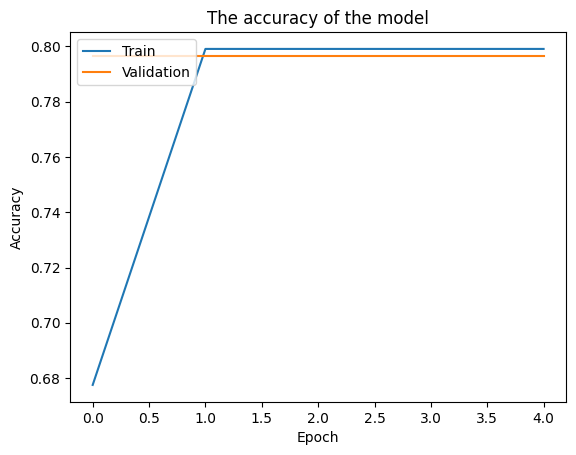

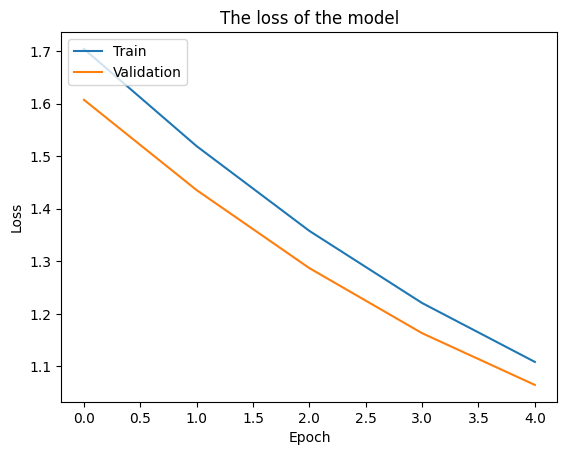

4/4 [==============================] - 2s 48ms/step
accuracy: 0.7676767676767676

classification report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        12
           5       0.77      1.00      0.87        76

    accuracy                           0.77        99
   macro avg       0.15      0.20      0.17        99
weighted avg       0.59      0.77      0.67        99


confusion matrix:
[[ 0  0  0  0  6]
 [ 0  0  0  0  2]
 [ 0  0  0  0  3]
 [ 0  0  0  0 12]
 [ 0  0  0  0 76]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
# Create a function to implement the RNN model
def imp_rnn(X_train, y_train, X_val, y_val, X_test, y_test, corpus_words):

    """A function implement the RNN model"""

    # Define hyperparameters for RNN
    max_length = 200 # The maximum length of sequence
    input_size = len(corpus_words) + 1 # Set the input size containing the total number of tokens
    hidden_size = 20 # Set the hidden dimension
    output_classes = 6 # For multiclass classification (5 classes for this case)
    num_layers = 2 # Set the number of layers of RNN model
    learning_rate = 0.001 # Set the value of learning rate
    num_epochs = 5 # Set the number of times for epochs

    # Define the RNN Model
    model = keras.Sequential([
            keras.layers.Embedding(input_dim=input_size, output_dim=hidden_size, input_length=max_length),
            keras.layers.Bidirectional(keras.layers.LSTM(hidden_size,  return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(hidden_size)),
            keras.layers.Dense(output_classes, activation='softmax'),
            ])

    # Use SGD optimizer
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

    # Compile the model before training the model to train dataset
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    # Train the model
    history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_val, y_val))

    # Print the loss and accuracy after testing the model.
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Testing loss: {loss}")
    print(f"Testing accuracy: {accuracy}")

    # Plot the graph to see the training and validation accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('The accuracy of the model')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot the graph to see the training and validation loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('The loss of the model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Test the model to predict the desired variable
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    return accuracy, class_report, conf_matrix

# Call the function to implement the RNN model
accuracy, class_report, conf_matrix = imp_rnn(X_train, y_train, X_val, y_val, X_test, y_test, corpus_words)

# Print the result
print("accuracy:", accuracy)
print("\nclassification report:")
print(class_report)
print("\nconfusion matrix:")
print(conf_matrix)

## 3. Sentiment Analysis with CNN
Please write the code to perform the sentiment analysis task you formulated in question 1. During the implementation, you will need to follow the requirements listed below. Feel free to use any packages and libraries.

In [10]:
# Download the embedding model
def load_embedding_model():

    """Load GloVe Vectors (wv_from_bin: All 400000 embeddings, each lengh 200)"""

    # Download the embedding model (Only the first time)
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")

    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))

    return wv_from_bin

wv_from_bin = load_embedding_model()

def get_matrix_of_vectors(wv_from_bin, required_words, dict_words):

    """A function to get the matrix of vectors of the required words"""

    # Get the vectors of the words from GloVe
    import random
    words = list(wv_from_bin.index_to_key)
    print("Shuffling words ...")
    random.seed(225)
    random.shuffle(words)
    words = words[:]
    print("Putting %i words into word2index and matrix M..." % len(required_words))
    embedding_matrix = []
    curIndex = 0
    default_vector = np.zeros(200)

    # Get the vectors of the required words
    for word in required_words:
        if word in words:
            embedding_matrix.append(wv_from_bin.get_vector(word))
        else:
            embedding_matrix.append(default_vector)

    embedding_matrix = np.stack(embedding_matrix)
    print("Done.")
    return embedding_matrix

# Call the function to get the vector matrices of the required words
embedding_matrix = get_matrix_of_vectors(wv_from_bin, corpus_words, dict_words)
embedding_matrix

Loaded vocab size 400000
Shuffling words ...
Putting 9697 words into word2index and matrix M...
Done.


array([[ 0.22586   ,  0.055649  ,  0.28367999, ..., -0.28356999,
         0.36353001, -0.87370002],
       [ 0.23273   , -0.048693  ,  0.76813   , ..., -0.55684   ,
        -0.44095999,  0.20299999],
       [-0.075412  ,  0.34158   , -0.66105002, ...,  0.14579   ,
        -0.57616001, -0.022035  ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.35547999,  0.22649001, -0.37088999, ..., -0.062321  ,
         0.19923   , -0.15657   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [11]:
# Define features and target variables
X = dataset['reviewText']
y = dataset['overall']

# Split the dataset into 3 parts including, train data, validation data, and test data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=100)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.1, random_state=100)

# Embedding layer from the words to be in numerical form
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)
word_tokenizer.fit_on_texts(X_val)
word_tokenizer.fit_on_texts(X_test)

X_train = word_tokenizer.texts_to_matrix(X_train)
X_val = word_tokenizer.texts_to_matrix(X_val)
X_test = word_tokenizer.texts_to_matrix(X_test)

# Padding all reviews to fixed length 200
max_length = 200
X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_val = pad_sequences(X_val, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)

Epoch 1/5
197/197 [==============================] - 28s 137ms/step - loss: 0.7789 - accuracy: 0.7871 - val_loss: 0.7621 - val_accuracy: 0.7964
Epoch 2/5
197/197 [==============================] - 25s 127ms/step - loss: 0.7418 - accuracy: 0.7991 - val_loss: 0.7517 - val_accuracy: 0.7964
Epoch 3/5
197/197 [==============================] - 26s 132ms/step - loss: 0.7416 - accuracy: 0.7991 - val_loss: 0.7527 - val_accuracy: 0.7964
Epoch 4/5
197/197 [==============================] - 31s 156ms/step - loss: 0.7407 - accuracy: 0.7991 - val_loss: 0.7514 - val_accuracy: 0.7964
Epoch 5/5
4/4 [==============================] - 0s 47ms/step - loss: 0.8825 - accuracy: 0.7677
Testing loss: 0.8824955821037292
Testing accuracy: 0.7676767706871033


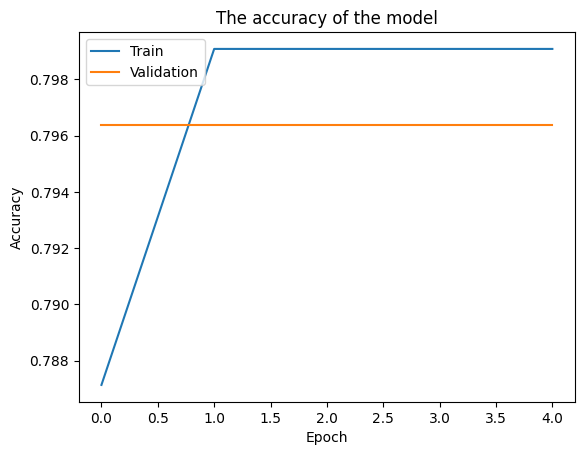

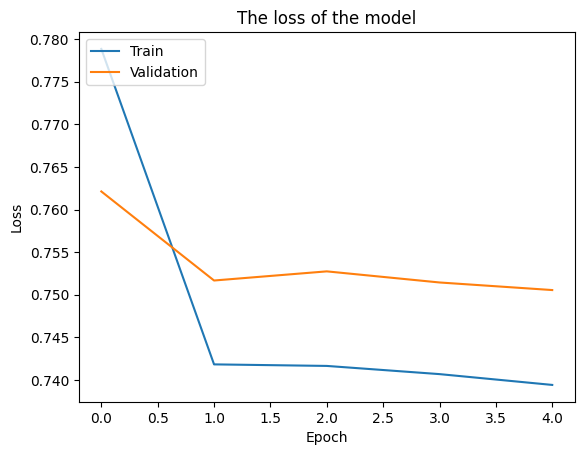

4/4 [==============================] - 0s 48ms/step
accuracy: 0.7676767676767676

classification report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        12
           5       0.77      1.00      0.87        76

    accuracy                           0.77        99
   macro avg       0.15      0.20      0.17        99
weighted avg       0.59      0.77      0.67        99


confusion matrix:
[[ 0  0  0  0  6]
 [ 0  0  0  0  2]
 [ 0  0  0  0  3]
 [ 0  0  0  0 12]
 [ 0  0  0  0 76]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
# Define the CNN model
def define_cnn_model(max_length, input_size, output_classes, learning_rate, embedding_matrix):

    """A function to define the CNN model"""

    # Create the input layer
    input_layer = Input(shape=(max_length,))

    # Create an Embedding layer (initialized randomly) - you can replace this with pre-trained embeddings
    embedding_layer = Embedding(input_dim=input_size, output_dim=max_length, weights=[embedding_matrix], input_length=max_length, trainable=False)(input_layer)

    # Apply convolutional layers
    conv1 = Conv1D(filters=100, kernel_size=3, activation='relu')(embedding_layer)
    conv2 = Conv1D(filters=100, kernel_size=4, activation='relu')(embedding_layer)
    conv3 = Conv1D(filters=100, kernel_size=5, activation='relu')(embedding_layer)

    # Apply max-pooling over the convolutional layers
    pool1 = GlobalMaxPooling1D()(conv1)
    pool2 = GlobalMaxPooling1D()(conv2)
    pool3 = GlobalMaxPooling1D()(conv3)

    # Concatenate pooled features
    merged = keras.layers.concatenate([pool1, pool2, pool3], axis=-1)

    # Fully connected layer for classification
    output_layer = Dense(output_classes, activation='softmax')(merged)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

def imp_cnn(X_train, y_train, X_val, y_val, X_test, y_test, max_length, input_size, output_classes, learning_rate, num_epochs, batch_size, embedding_matrix):

    """A function to implement the CNN model"""

    # Create the function to define the CNN model
    model = define_cnn_model(max_length, input_size, output_classes, learning_rate, embedding_matrix)

    # Define the optimizer
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

    # Compile the model before training the model to train dataset.
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model with mini-batch gradient descent
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_val, y_val))

    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Testing loss: {loss}")
    print(f"Testing accuracy: {accuracy}")

    # Plot the graph to see the training and validation accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('The accuracy of the model')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot the graph to see the training and validation loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('The loss of the model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Predict on the test set
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    return accuracy, class_report, conf_matrix

# Define hyperparameters for CNN
max_length = 200 # Set the maximum length of sequence
input_size = len(corpus_words) # Set the input size
output_classes = 6 # For multiclass classification (5 classes for this case)
learning_rate = 0.001 # Set the value of learning rate
num_epochs = 5 # Set the number of times for epochs
batch_size = 20 # Define the batch size

# Call the function to implement the CNN model
accuracy, class_report, conf_matrix = imp_cnn(X_train, y_train, X_val, y_val, X_test, y_test, max_length, input_size, output_classes, learning_rate, num_epochs, batch_size, embedding_matrix)

# Print the result
print("accuracy:", accuracy)
print("\nclassification report:")
print(class_report)
print("\nconfusion matrix:")
print(conf_matrix)

## 4. Evaluation
Train the model on the training set, select the best model based on the validation set, and evaluate your model on the testing set.
<br>(1) Evaluate the model performance using metrics for classification, such as accuracy, precision, recall, F1-score, and AUC. Report your results for both methods.

**Answer: I have already printed the result in the 2nd and 3rd tasks**

(2) Have a brief discussion to compare the performance of the two models. It should be noted that there is no fixed answer for the results. You will need to report the exact results returned in your experiments. The discussions should only be based on your own experimental settings and returned results.

**Answer: The performance of the two models appears to be quite similar, as shown above. After attempting to adjust the parameters to achieve the best performance for these two models, I discovered that both models completely predicted the reviews in the test data as having a score of 5 (positive reviews).**

**I believe that the reason the models are exclusively predicting reviews with a score of 5 is due to insufficient data. The statistics table indicates that a large portion of the reviews have a score of 5 compared to other scores, which could potentially dominate the model's ability to learn meaningful patterns and result in the exclusive prediction of reviews with a score of 5.**

**To solve this situation, we need more review data with 1-4 scores. The number of reviews for each score should not be much different.**

(3) Are there any differences between the results you obtained in HW1 and HW2? Which model performs best? Can you please provide some discussions about your findings? It would be great to think about and discuss the underlying reasons for the outperformance of the best model.

**Answer: The differences between the results in HW1 and HW2 are quite significant. In HW1, I implemented a Logistic Regression model and a Neural Network model for binary sentiment classification, focusing on the prediction of only positive or negative reviews. These models are much simpler compared to implementing RNN and CNN models for multi-class sentiment classification in HW2.**

**In HW1, I achieved a very decent result with an accuracy of over 90% in predictions. This success can be attributed to the binary classification approach, where reviews with scores from 0 to 3 were considered negative, and the rest were considered positive. This approach ensured that reviews with a score of 5 did not dominate the model's ability to learn meaningful patterns for predictions.**

**On the other hand, in HW2, using RNN and CNN models for multi-class sentiment classification proved to be a more complex task, which required a larger and more diverse dataset for training. The data I used in HW2 appeared to be insufficient because a substantial portion of the reviews had a score of 5 compared to other score values. This imbalance in the dataset may have caused the models to focus predominantly on predicting reviews with a score of 5.**

**In conclusion, based on my experiments, I believe that for this specific case, simpler models like the ones used in HW1 tend to perform better. However, if we had access to a larger and more diverse dataset, the more complex RNN and CNN models could potentially outperform the simpler models for predictions.**